tensor([-3.1717e-01,  2.4622e-01,  7.3672e-01,  2.1838e-01,  3.5957e-01,
         1.1492e-01,  1.8277e-01, -7.1010e-02, -8.3714e-02,  3.3669e-01,
        -5.7636e-02, -3.1853e-01,  6.8799e-02,  1.1276e-01, -3.2839e-01,
         4.5270e-01,  3.6288e-01,  1.4180e-01,  3.3045e-01,  4.2296e-01,
        -1.2998e-01,  2.5090e-01, -7.0473e-03, -3.8354e-02, -4.7649e-02,
         5.4574e-01,  4.2656e-01,  1.8924e-01,  2.2715e-01,  4.2921e-01,
         6.7998e-01,  4.6277e-01,  5.3623e-01,  5.4100e-01,  3.3275e-01,
         3.0644e-01,  2.8834e-01,  4.7428e-01,  5.9365e-01,  3.7643e-01,
         2.7329e-01,  7.1809e-01,  3.1272e-01,  3.6748e-01,  2.6674e-01,
         2.1013e-01,  6.1932e-01,  1.5126e-01,  1.8896e-01,  3.6310e-01,
         5.5778e-01,  4.1770e-01,  7.0239e-01,  4.2003e-01,  6.4014e-01,
         8.3101e-01,  7.4478e-01,  7.3642e-01,  6.3031e-01,  4.6115e-01,
         2.0019e-01,  9.5699e-01,  4.5368e-01,  7.7773e-01,  6.4180e-01,
         3.4130e-01,  6.3895e-01,  3.5952e-01,  8.6

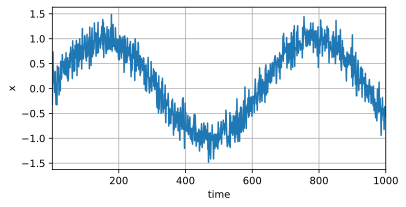

In [6]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

T = 1000 # 总共产⽣1000个点
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))
x

In [11]:
tau = 4
features = torch.zeros((T - tau, tau))
features

tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])

In [10]:
tau = 4
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i:T - tau + i]
labels = x[tau:].reshape((-1, 1))

batch_size, n_train = 16, 600
# 只有前`n_train`个样本⽤于训练
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)

features

tensor([[-0.3172,  0.2462,  0.7367,  0.2184],
        [ 0.2462,  0.7367,  0.2184,  0.3596],
        [ 0.7367,  0.2184,  0.3596,  0.1149],
        ...,
        [-0.4069, -0.8230, -0.5173, -0.3648],
        [-0.8230, -0.5173, -0.3648, -0.5057],
        [-0.5173, -0.3648, -0.5057, -0.5581]])

In [3]:
# 初始化⽹络权重的函数
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
# ⼀个简单的多层感知机
def get_net():
    net = nn.Sequential(nn.Linear(4, 10), nn.ReLU(), nn.Linear(10, 1))
    net.apply(init_weights)
    return net
# 平⽅损失
loss = nn.MSELoss()

In [4]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
                f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss: 0.069046
epoch 2, loss: 0.052626
epoch 3, loss: 0.051126
epoch 4, loss: 0.050903
epoch 5, loss: 0.051003


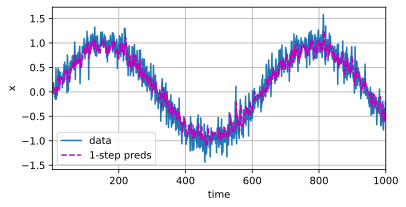

In [5]:
onestep_preds = net(features)
d2l.plot(
[time, time[tau:]],
[x.detach().numpy(), onestep_preds.detach().numpy()], 'time', 'x',
legend=['data', '1-step preds'], xlim=[1, 1000], figsize=(6, 3))

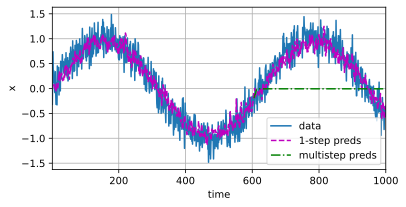

In [13]:
multistep_preds = torch.zeros(T)
multistep_preds[:n_train + tau] = x[:n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(multistep_preds[i - tau:i].reshape((1, -1)))
d2l.plot([time, time[tau:], time[n_train + tau:]], [
x.detach().numpy(),
onestep_preds.detach().numpy(),
multistep_preds[n_train + tau:].detach().numpy()], 'time', 'x',
legend=['data', '1-step preds',
'multistep preds'], xlim=[1, 1000], figsize=(6, 3))

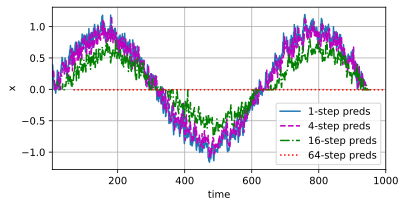

In [17]:
max_steps = 64
features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# 列 `i` (`i` < `tau`) 是来⾃ `x` 的观测
# 其时间步从 `i + 1` 到 `i + T - tau - max_steps + 1`
for i in range(tau):
    features[:, i] = x[i:i + T - tau - max_steps + 1]
# 列 `i` (`i` >= `tau`) 是 (`i - tau + 1`)步的预测
# 其时间步从 `i + 1` 到 `i + T - tau - max_steps + 1`
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1:T - max_steps + i] for i in steps],
[features[:, (tau + i - 1)].detach().numpy() for i in steps], 'time',
'x', legend=[f'{i}-step preds'
for i in steps], xlim=[5, 1000], figsize=(6, 3))